<a href="https://colab.research.google.com/github/agroimpacts/adleo/blob/devel/assignments/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: CNNs

## Instructions

To submit the assignment, you will need to use GitHub and the existing private repository you already created called `adleoxyz` (xyz is your initials)

Once you have completed the assignment:
- Commit your notebook from colab to your private GitHub repo
- The notebook should be named assignment2_xyz.ipynb, with xyz again replaced by your initials.

## Coding assignment 1

Follow the instructions below to complete your coding assignment **(30 points)**

### Static code 1

Run the following cells unchanged

#### Mount drive and run imports

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
!pip install pillow_heif
from PIL import Image
import requests
import io
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.utils as utils
import torch.utils.data as data

import torchvision.transforms.v2 as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time


from IPython.core.debugger import set_trace

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.6 MB/s eta 0:00:00


#### Variables to set

Model save path: Modify 'save_dir' to the path to your already downloaded MNIST dataset (from assignment 1).

In [4]:
save_dir = "/content/gdrive/MyDrive/adleo/data"

### Transforms and loads (Steps 1.1-1.5)

### Task 1: Necessary transforms - write your own version!

In this task, you are asked to update the transformation code you wrote in Assignment 1 by **adding geometric and color transformations to the transforms**.

To solve this task, you can check the [Torchvision Transforms Documentation](https://pytorch.org/vision/stable/transforms.html) for details on `RandomHorizontalFlip`, `RandomVerticalFlip`, and `ColorJitter`.  


**Note:**

The transforms pipeline applies a series of augmentations and preprocessing steps to images before feeding them into a model.

`RandomHorizontalFlip(p=0.5)` → Flips the image horizontally with a 50% probability.

`RandomVerticalFlip(p=0.2)` → Flips the image vertically with a 20% probability.

`ColorJitter(brightness, contrast, saturation, hue)` → Randomly adjusts brightness, contrast, saturation, and hue to introduce color variations.

Did you notice that the best practice is to apply all transformations that expect PIL images or NumPy arrays as input before converting the image to a tensor `ToImage()`? Once the image is a tensor, only tensor-compatible transformations can be applied!

#### Code to complete for Task 1

In [ ]:
# Please update this part to the complete the task

random_horizontal_flip = transforms.RandomHorizontalFlip(p=0.5)
random_vertical_flip = transforms.RandomVerticalFlip(p=0.5)
random_resize_transform = transforms.RandomResize(128, 256)
scale_jitter_transform = transforms.ScaleJitter(target_size=(224, 224),scale_range=(0.8, 1.2))
random_crop_transform = transforms.RandomCrop(size=(128, 128), padding= 4)
color_jitter_transform = transforms.ColorJitter(brightness=0.2,contrast=0.3,saturation=0.4,hue=0.1)

mnist_mean = 0.13066048920154572
mnist_std = 0.30810779333114624

train_transforms = transforms.Compose(
    [transforms.RandomRotation(5, fill=(0,)),
     transforms.RandomCrop(28, padding=2),
     transforms.ToImage(),
     transforms.ToDtype(torch.float32, scale=True),
     transforms.Normalize(mean=[mnist_mean], std=[mnist_std])]
)

test_transforms = transforms.Compose(
    [transforms.ToImage(),
     transforms.ToDtype(torch.float32, scale=True),
     transforms.Normalize(mean=[mnist_mean], std=[mnist_std])]
)

#### Load and split

In [ ]:
train_data = datasets.MNIST(root=save_dir,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=save_dir,
                           train=False,
                           download=False,
                           transform=test_transforms)

train_ratio = 0.9

n_train_examples = int(len(train_data) * train_ratio)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(
    train_data,
    [n_train_examples, n_valid_examples]
)

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

#### Make iterable

In [ ]:
# define batch size first
train_bsize = 54   # training batch size--can change for optional part

In [ ]:
# Don't change this cell
train_loader = data.DataLoader(train_data,
                               shuffle=True,
                               batch_size=train_bsize)

valid_loader = data.DataLoader(valid_data,
                               shuffle=False,
                               batch_size=train_bsize)

test_loader = data.DataLoader(test_data,
                              shuffle=False,
                              batch_size=train_bsize)

#### Metrics and some other necessary functions

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for x, y in tqdm(iterator, desc="Training", leave=False):

        x, y = x.to(device), y.to(device)

        y_pred = model(x)

        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    # Disable autograd for evaluation
    with torch.no_grad():
        for x, y in tqdm(iterator, desc="Evaluating", leave=False):

            x, y = x.to(device), y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


### Task 2: Create your CNN model

Using the blueprint and starter code provided in the CNN practical, section 4.1, for LeNet, create your `MyLetNet` model. The starter code is provide in the cell below.  Please complete it.

In [ ]:
## Class here
class myLeNet(nn.Module):
  def __init__(self, in_dim, num_classes):
    super(myLeNet, self).__init__()
        # feature extraction part
    self.conv1 = nn.Sequential(
    nn.Conv2d(in_channels=in_dim, out_channels=6, kernel_size=5, stride=1, padding=2),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2)
        )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2))


        # classification part
    self.classifier = nn.Sequential(
        nn.Linear(16 * 5 * 5, 120),
        nn.ReLU(inplace=True),
        nn.Linear(120, 84),
        nn.ReLU(inplace=True),
        nn.Linear(84, num_classes)
    )

  def forward(self, x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = torch.flatten(x, start_dim=1)
      x = self.classifier(x)
      return x

Define the parameters needed to run the model

In [ ]:
in_dim = 1
initial_lr = 0.001    # Hyper-parameter that you can change for optional part
num_epochs = 10    # Hyper-parameter that you can change for optional part

# new variables
num_classes = 10

### Task 3: Show your work, and modify training to include gradient clipping

#### Run and print the model

In [ ]:
# Don't change this cell
model = myLeNet(in_dim, num_classes=num_classes)
print(model)

myLeNet(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


#### Show the number of parameters in the model

In [ ]:
# Don't change this cell
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 61,706 trainable parameters


#### Optimizer, loss criterion, and GPU/CPU switch

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=initial_lr)
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

#### Train the model, complete code to add gradient clipping

Modify the training loop to prevent exploding gradients by adding gradient clipping.

**Hint**:
Gradient clipping limits the maximum gradient norm to prevent instability during training.

It should be added after calling backward() (which computes gradients) but before optimizer.step() (which updates weights).

You can use this function: `torch.nn.utils.clip_grad_norm_`

Look into PyTorch’s [`torch.nn.utils`](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.clip_grad_norm_) module for a function that clips gradients to a given `max_norm`.

In [ ]:
# Please change the code according to the question:

best_val_loss = float('inf')
train_loss_per_epoch = []
val_loss_per_epoch = []
epoch_counter = []

for epoch in trange(num_epochs):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion,
                                  device)
    val_loss, val_acc = evaluate(model, valid_loader, criterion, device)

    #simple implementation of early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_mlp_tutorial.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')

    epoch_counter.append(epoch)
    train_loss_per_epoch.append(train_loss)
    val_loss_per_epoch.append(val_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 55s
	Train Loss: 0.343 | Train Acc: 89.12%
	 Val. Loss: 0.075 |  Val. Acc: 97.59%


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 57s
	Train Loss: 0.099 | Train Acc: 97.05%
	 Val. Loss: 0.043 |  Val. Acc: 98.48%


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 59s
	Train Loss: 0.075 | Train Acc: 97.68%
	 Val. Loss: 0.038 |  Val. Acc: 98.76%


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 56s
	Train Loss: 0.061 | Train Acc: 98.16%
	 Val. Loss: 0.040 |  Val. Acc: 98.73%


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 55s
	Train Loss: 0.054 | Train Acc: 98.37%
	 Val. Loss: 0.031 |  Val. Acc: 98.97%


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 56s
	Train Loss: 0.050 | Train Acc: 98.47%
	 Val. Loss: 0.042 |  Val. Acc: 98.78%


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 56s
	Train Loss: 0.046 | Train Acc: 98.57%
	 Val. Loss: 0.029 |  Val. Acc: 99.16%


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 56s
	Train Loss: 0.042 | Train Acc: 98.65%
	 Val. Loss: 0.037 |  Val. Acc: 98.94%


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 56s
	Train Loss: 0.039 | Train Acc: 98.81%
	 Val. Loss: 0.038 |  Val. Acc: 98.88%


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 56s
	Train Loss: 0.039 | Train Acc: 98.79%
	 Val. Loss: 0.030 |  Val. Acc: 99.06%


#### Plot the results

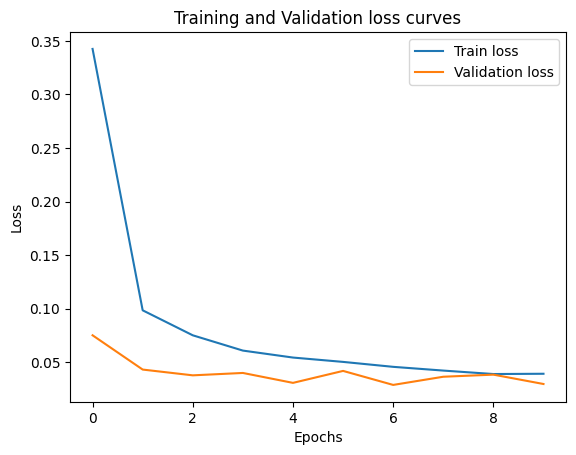

In [ ]:
plt.plot(epoch_counter, train_loss_per_epoch, label="Train loss")
plt.plot(epoch_counter, val_loss_per_epoch, label="Validation loss")
plt.title("Training and Validation loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

#### Evaluate the performance

In [ ]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/186 [00:00<?, ?it/s]

Test Loss: 0.028 | Test Acc: 99.12%


#### Show the matrix

## Coding assignment 2

- Download a picture from internet that is among the 1000 classes of the ImageNet dataset labels. Choose five different pre-trained models in torchvision and report the top-1 accuracy related to each model.

- Source and make accessible your image using one of the two following approaches:

    - Link to the image you have chosen if its available on the web. If the image is in your local machine, you can either upload it in your github repo with the name infer_img_assgn2.
    - Alternatively, copy the image to your gdrive and give it permission for everyone with the link (right click the image --> share with google Drive).

- Then select three of the twelve main pre-trained models in `TorchVision` that are to be used for classifying images from the fine-grained inter-species data sets. Notice that some models include multiple varieties, so you can select one of those varieties for a particular class.

- **20 points**

### Static code 3



#### Step 1. Load pre-trained models

Load up models and inspect names. Note that we use here a slightly more compact approach to printing the model names.

This combines the packages and model loads for simplicity.


In [5]:
import requests
import torchvision
import torch.utils.model_zoo as model_zoo
import torchvision.models as models
from PIL import Image

# model names
model_names = sorted(name for name in models.__dict__ \
                     if name.islower() and not name.startswith("__"))
# print(model_names)
mod_index = np.linspace(start=0, stop=len(model_names), num=20) \
              .astype('int').tolist()
for i in range(len(mod_index[:-1])):
    print(model_names[mod_index[i]:mod_index[i+1]])

['_api', '_meta', '_utils', 'alexnet', 'convnext']
['convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet', 'densenet121']
['densenet161', 'densenet169', 'densenet201', 'detection', 'efficientnet', 'efficientnet_b0']
['efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5']
['efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'get_model']
['get_model_builder', 'get_model_weights', 'get_weight', 'googlenet', 'inception', 'inception_v3']
['list_models', 'maxvit', 'maxvit_t', 'mnasnet', 'mnasnet0_5', 'mnasnet0_75']
['mnasnet1_0', 'mnasnet1_3', 'mobilenet', 'mobilenet_v2', 'mobilenet_v3_large']
['mobilenet_v3_small', 'mobilenetv2', 'mobilenetv3', 'optical_flow', 'quantization', 'regnet']
['regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf']
['regnet_x_8gf', 'regnet_y_128gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf', 

#### Step 2: transform function

Needed to make your selected image fit with the model


In [6]:
transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToImage(),
  transforms.ToDtype(torch.float32, scale=True),
  transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
  )])


### Code to modify

#### Step 3: Load up your image

Remember to replace either the URL with one pointing to the image you want to classify, or if you are downloading your image, comment out the load from url `Image.open` line and uncomment the load from file version, with your correct file path in it.

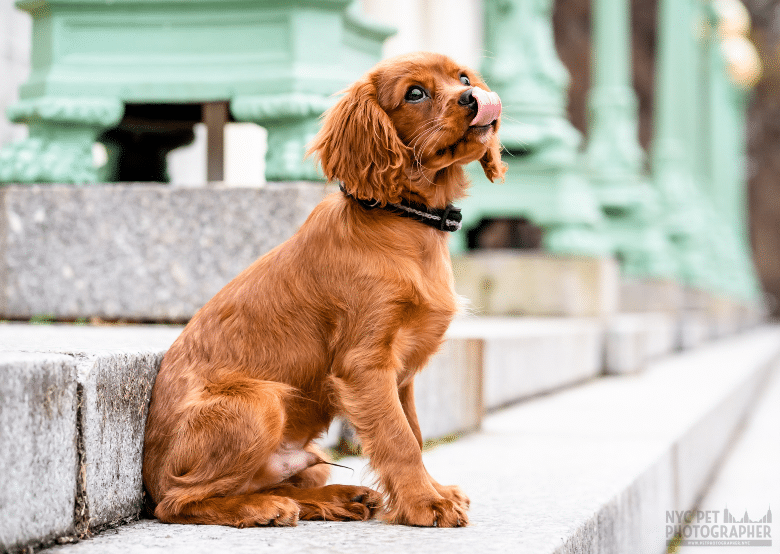

In [7]:
url = ("https://www.thisdogslife.co/wp-content/uploads/2020/08/" + \
       "Dog-Photoshoot-Tips.png")
img = Image.open(requests.get(url, stream=True).raw)
# uncomment this one to load in downloaded image, adjust path as needed
# img = Image.open("/content/gdrive/MyDrive/Dog-Photoshoot-Tips-3.png")

img = img.convert("RGB")
img_trans = transform(img)
batch_t = torch.unsqueeze(img_trans, 0)
img  ## this lets us see your image

#### Step 4: Load up class definitions

Use either the downloaded version, or, for the **extra 1 point**, show the method you used to pull it directly from its URL.,  the link to download the data is [ImageNet Class Index](https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt)  

Downloaded version

In [8]:
# Change the paths accordingly
drive_path = "/content/gdrive/MyDrive/"
imagenet_class_path = f"{drive_path}/adleo/data/imagenet/imagenet_classes.txt"
with open(imagenet_class_path) as f:
    labels = [line.strip() for line in f.readlines()]

FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/MyDrive//adleo/data/imagenet/imagenet_classes.txt'

### Demonstrate your three selected models

Use the spaces below (for Models 1-3) to run each of your 3 selected pre-trained models. The Demo immediately below shows how to do this with `AlexNet`.

#### Demo

In [9]:
# create model objects and look at its internals
alexnet = models.alexnet(weights="DEFAULT")  # model
print(alexnet)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 141MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Check out the pooling layer and classifier. Note the name of the pooling layers will be different in different models. Please change accordingly.

In [10]:
print(alexnet.avgpool)
print("%" * 20)
print(alexnet.classifier)

AdaptiveAvgPool2d(output_size=(6, 6))
%%%%%%%%%%%%%%%%%%%%
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


Report the accuracy metrics

In [11]:
alexnet.eval()
out_vec = alexnet(batch_t)
print(out_vec.shape)

print("%" * 20)
percentage = torch.nn.functional.softmax(out_vec, dim=1)[0] * 100
_, indices = torch.sort(out_vec, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

torch.Size([1, 1000])
%%%%%%%%%%%%%%%%%%%%


NameError: name 'labels' is not defined

#### Model 1

In [12]:
model1 = models.resnet18(pretrained=True)
print(model1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img_trans = transform(img)
batch_t = torch.unsqueeze(img_trans, 0)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [17]:
model1.eval()

out_vec1 = model1(batch_t)
print(out_vec.shape)

torch.Size([1, 1000])


In [23]:
# Change the path accordingly
drive_path = "/content/gdrive/MyDrive/"
imagenet_class_path = f"{drive_path}/adleo/data/imagenet_classes.txt"
with open(imagenet_class_path) as f:
    labels = [line.strip() for line in f.readlines()]
labels[0:3]

_, index = torch.max(out_vec1, 1) # Returns the max value and its index
                                 # Note that _ is a throwaway variable
                                 # we use it when we don't need to store
                                 # the value.

percentage = torch.nn.functional.softmax(out_vec1, dim=1)[0] * 100

print(labels[index[0]], percentage[index[0]].item())

cocker spaniel, English cocker spaniel, cocker 35.50707244873047


#### Model 2

In [20]:
model2 = models.densenet121(pretrained=True)
print(model2)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 99.6MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [21]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [29]:
model2.eval()

out_vec2 = model2(batch_t)
print(out_vec.shape)

torch.Size([1, 1000])


In [30]:
# Change the path accordingly
drive_path = "/content/gdrive/MyDrive/"
imagenet_class_path = f"{drive_path}/adleo/data/imagenet_classes.txt"
with open(imagenet_class_path) as f:
    labels = [line.strip() for line in f.readlines()]
labels[0:3]

_, index = torch.max(out_vec2, 1) # Returns the max value and its index
                                 # Note that _ is a throwaway variable
                                 # we use it when we don't need to store
                                 # the value.

percentage = torch.nn.functional.softmax(out_vec2, dim=1)[0] * 100

print(labels[index[0]], percentage[index[0]].item())

Irish setter, red setter 69.02295684814453


#### Model 3

In [26]:
model3 = models.wide_resnet50_2(pretrained=True)
print(model3)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:01<00:00, 107MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [27]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [28]:
model3.eval()

out_vec3 = model3(batch_t)
print(out_vec.shape)

torch.Size([1, 1000])


In [31]:
# Change the path accordingly
drive_path = "/content/gdrive/MyDrive/"
imagenet_class_path = f"{drive_path}/adleo/data/imagenet_classes.txt"
with open(imagenet_class_path) as f:
    labels = [line.strip() for line in f.readlines()]
labels[0:3]

_, index = torch.max(out_vec3, 1) # Returns the max value and its index
                                 # Note that _ is a throwaway variable
                                 # we use it when we don't need to store
                                 # the value.

percentage = torch.nn.functional.softmax(out_vec3, dim=1)[0] * 100

print(labels[index[0]], percentage[index[0]].item())

Irish setter, red setter 85.36019897460938


In [ ]:
### I used copilot and gemini primarily for debugging in this assignment. I have attached my copilot conversation below as it doesn't allow for sharing via link. I used gemini only in its capability included in colab to input a printed error for debugging.

# what parts of this web page talk about geometric and color transformatons
# Copilot
# The web page discusses geometric and color transformations in several sections:

# Geometric Transformations:

# Resizing: This includes functions like v2.Resize, v2.RandomResizedCrop, and v2.ScaleJitter.

# Cropping: Functions such as v2.RandomCrop, v2.CenterCrop, and v2.FiveCrop.

# Flipping and Rotating: Functions like v2.RandomHorizontalFlip, v2.RandomVerticalFlip, and v2.RandomRotation.

# Affine and Perspective Transformations: Functions like v2.RandomAffine and v2.RandomPerspective.

# Color Transformations:

# Color Adjustments: Functions like v2.ColorJitter, v2.RandomGrayscale, and v2.GaussianBlur.

# Channel Manipulations: Functions such as v2.RandomChannelPermutation and v2.RandomInvert.

# Noise and Sharpness Adjustments: Functions like v2.GaussianNoise and v2.RandomAdjustSharpness.

# These sections provide detailed information on how to apply these transformations to images or videos. If you need more specific details, feel free to ask!




# You
# when it says v2.RandomResize(min_size, max_size[, ...])

# what does the ... represent?
# Copilot
# The ... in v2.RandomResize(min_size, max_size[, ...]) represents optional additional parameters that can be passed to the function. These optional parameters typically include things like interpolation methods, antialiasing, and other settings that can customize the resizing behavior.

# For example, v2.RandomResize might accept parameters like:

# interpolation: Specifies the interpolation method to use (e.g., bilinear, bicubic).

# antialias: A boolean indicating whether to use antialiasing.

# Here is an example usage with optional parameters:

# python

# Copy
# v2.RandomResize(min_size=224, max_size=256, interpolation='bilinear', antialias=True)
# This means you can fine-tune the transformation by specifying these optional parameters as needed. If you have any specific questions about these parameters, let me know!




# You
# so the ... does not represent any necessary parameters?
# Copilot
# Correct! The ... in v2.RandomResize(min_size, max_size[, ...]) indicates that there are optional parameters available, but none of them are necessary for the function to work. The only required parameters are min_size and max_size. The optional parameters can be used to fine-tune the resizing behavior as needed. So, you can use the function with just the required parameters like this:

# python

# Copy
# v2.RandomResize(min_size=224, max_size=256)
# Or, if you want to specify additional parameters:

# python

# Copy
# v2.RandomResize(min_size=224, max_size=256, interpolation='bilinear', antialias=True)
# You can choose which optional parameters to include based on your specific requirements.




# You
# what would be example values for random resize
# Copilot
# Here's an example of how you can use the v2.RandomResize function with different values:

# python

# Copy
# import torchvision.transforms.v2 as transforms

# # Example values for RandomResize
# min_size = 128
# max_size = 256

# # Creating the RandomResize transformation
# random_resize_transform = transforms.RandomResize(min_size=min_size, max_size=max_size, interpolation='bilinear', antialias=True)

# # Applying the transformation to an example image
# transformed_image = random_resize_transform(example_image)
# In this example:

# min_size is set to 128, meaning the smallest size of the resized image will be 128 pixels.

# max_size is set to 256, meaning the largest size of the resized image will be 256 pixels.

# interpolation is set to 'bilinear' for the interpolation method.

# antialias is set to True to enable antialiasing.

# You can adjust the min_size and max_size values based on your specific requirements. The interpolation and antialiasing parameters are optional and can be omitted if not needed. Here's a simplified version without optional parameters:

# python

# Copy
# # Creating the RandomResize transformation without optional parameters
# random_resize_transform = transforms.RandomResize(min_size=128, max_size=256)

# # Applying the transformation to an example image
# transformed_image = random_resize_transform(example_image)
# Feel free to experiment with different values to see how they affect the resizing of your images!




# You
# and what would the scale jitter look like with example values?
# Copilot
# Sure! Here's an example of how to use the v2.ScaleJitter transformation with example values:

# python

# Copy
# import torchvision.transforms.v2 as transforms

# # Example values for ScaleJitter
# target_size = (224, 224)
# scale_range = (0.8, 1.2)

# # Creating the ScaleJitter transformation
# scale_jitter_transform = transforms.ScaleJitter(target_size=target_size, scale_range=scale_range)

# # Applying the transformation to an example image
# transformed_image = scale_jitter_transform(example_image)
# In this example:

# target_size is set to (224, 224), meaning the output image will be resized to 224x224 pixels.

# scale_range is set to (0.8, 1.2), meaning the input image will be randomly scaled by a factor between 0.8 and 1.2 before being resized to the target size.

# Feel free to adjust the target_size and scale_range values based on your specific requirements. This will help you create a variety of images with different scales, making your model more robust to changes in input image sizes!




# You
# what would it look like just filling out this definition:
# v2.ScaleJitter(target_size[, scale_range, ...])
# Copilot
# Here's an example of how the v2.ScaleJitter function might look with both required and optional parameters filled out:

# python

# Copy
# import torchvision.transforms.v2 as transforms

# # Example values for ScaleJitter
# target_size = (224, 224)
# scale_range = (0.8, 1.2)
# optional_param1 = "value1"
# optional_param2 = "value2"

# # Creating the ScaleJitter transformation
# scale_jitter_transform = transforms.ScaleJitter(
#     target_size=target_size,
#     scale_range=scale_range,
#     optional_param1=optional_param1,
#     optional_param2=optional_param2
# )

# # Applying the transformation to an example image
# transformed_image = scale_jitter_transform(example_image)
# In this example:

# target_size is set to (224, 224), meaning the output image will be resized to 224x224 pixels.

# scale_range is set to (0.8, 1.2), meaning the input image will be randomly scaled by a factor between 0.8 and 1.2 before being resized to the target size.

# optional_param1 and optional_param2 are placeholders for any additional optional parameters that you might want to include, such as interpolation methods or other settings.

# Feel free to replace optional_param1 and optional_param2 with actual parameter names and values based on your specific needs. If you have any specific questions about the optional parameters, let me know!




# You
# what would be an example of random crop?
# Copilot
# Here's an example of how to use the v2.RandomCrop function with some example values:

# python

# Copy
# import torchvision.transforms.v2 as transforms

# # Example values for RandomCrop
# crop_size = (128, 128)
# padding = 4

# # Creating the RandomCrop transformation
# random_crop_transform = transforms.RandomCrop(size=crop_size, padding=padding)

# # Applying the transformation to an example image
# transformed_image = random_crop_transform(example_image)
# In this example:

# crop_size is set to (128, 128), meaning the output image will be cropped to 128x128 pixels.

# padding is set to 4, meaning a padding of 4 pixels will be added to each side of the image before cropping.

# Feel free to adjust the size and padding values based on your specific requirements. You can also omit the padding parameter if you don't need it:

# python

# Copy
# # Creating the RandomCrop transformation without padding
# random_crop_transform = transforms.RandomCrop(size=(128, 128))

# # Applying the transformation to an example image
# transformed_image = random_crop_transform(example_image)
# This will crop the image at a random location to the specified size without adding any padding. If you have any more questions or need further examples, just let me know!




# You
# what would it look like for color jitter?
# Copilot
# Here's an example of how to use the v2.ColorJitter function with some example values:

# python

# Copy
# import torchvision.transforms.v2 as transforms

# # Example values for ColorJitter
# brightness = 0.2
# contrast = 0.3
# saturation = 0.4
# hue = 0.1

# # Creating the ColorJitter transformation
# color_jitter_transform = transforms.ColorJitter(
#     brightness=brightness,
#     contrast=contrast,
#     saturation=saturation,
#     hue=hue
# )

# # Applying the transformation to an example image
# transformed_image = color_jitter_transform(example_image)
# In this example:

# brightness is set to 0.2, meaning the brightness of the image will be adjusted randomly by up to 20%.

# contrast is set to 0.3, meaning the contrast of the image will be adjusted randomly by up to 30%.

# saturation is set to 0.4, meaning the saturation of the image will be adjusted randomly by up to 40%.

# hue is set to 0.1, meaning the hue of the image will be adjusted randomly by up to 10%.

# You can adjust these parameters to suit your needs, and even omit some if you don't need all of them. The ColorJitter transformation helps create a variety of color variations in your dataset, making your model more robust to different lighting conditions and color changes. If you need more examples or have other questions, feel free to ask!




# You
# how is this code supposed to look?

# random_horizontal_flip = RandomHorizontalFlip(p=0.5)
# random_vertical_flip = RandomVerticalFlip(p=0.5)
# Copilot
# Here's how the code should look when you import the necessary modules from torchvision.transforms and define the transformations:

# python

# Copy
# import torchvision.transforms as transforms

# # Creating RandomHorizontalFlip and RandomVerticalFlip transformations
# random_horizontal_flip = transforms.RandomHorizontalFlip(p=0.5)
# random_vertical_flip = transforms.RandomVerticalFlip(p=0.5)

# # Applying the transformations to an example image (example_image)
# transformed_image_horizontal = random_horizontal_flip(example_image)
# transformed_image_vertical = random_vertical_flip(example_image)
# In this code:

# The transforms.RandomHorizontalFlip(p=0.5) will flip the image horizontally with a 50% probability.

# The transforms.RandomVerticalFlip(p=0.5) will flip the image vertically with a 50% probability.

# Make sure you have torchvision installed, and replace example_image with the actual image you want to apply the transformations to. If you have any more questions or need further examples, feel free to ask!




# You
# please explain conceptually what is missing from this code:
# ## Class here
# class myLeNet(nn.Module):
#     def __init__(self, in_dim, num_classes):
#         super(myLeNet, self).__init__()
#         # feature extraction part
#         self.conv1 = nn.Sequential...
#         ...

#         # classification part
#         self.classifier = nn.Sequential(
#             nn.Linear(...
#             nn.ReLU(inplace = True),
#             ..
#             ..
#             ..
#         )

#     def forward(self, x):
#         # set_trace()
#         conv1 = self.conv1(x)
#         ...
#         ...
#         ...
#         x = torch.flatten(..
#         predict = self.classifier(x)
#         return predict
# Copilot
# Your myLeNet class definition is incomplete. Here's a conceptual breakdown of what is missing:

# Feature Extraction Part: You need to define the convolutional layers that will extract features from the input data. This might include multiple nn.Conv2d layers followed by activation functions like nn.ReLU and pooling layers like nn.MaxPool2d.

# Sequential Container for Conv Layers: The nn.Sequential... part should include the detailed layers for the feature extraction. For example:

# python

# Copy
# self.conv1 = nn.Sequential(
#     nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
#     nn.ReLU(inplace=True),
#     nn.MaxPool2d(kernel_size, stride, padding),
#     ...
# )
# Linear Layers in Classifier Part: You need to fully define the layers in the nn.Sequential container for the classifier. This typically includes several nn.Linear layers followed by activation functions and dropout layers if needed. For example:

# python

# Copy
# self.classifier = nn.Sequential(
#     nn.Linear(in_features, hidden_units),
#     nn.ReLU(inplace=True),
#     nn.Dropout(p=0.5),
#     nn.Linear(hidden_units, num_classes)
# )
# Forward Method: Ensure that the forward method passes the input through all the defined layers. You also need to flatten the output of the convolutional layers before passing it to the classifier:

# python

# Copy
# def forward(self, x):
#     x = self.conv1(x)
#     x = self.conv2(x)  # If you have multiple conv layers
#     ...
#     x = torch.flatten(x, start_dim=1)
#     x = self.classifier(x)
#     return x
# Here's a more complete version of your class:

# python

# Copy
# import torch
# import torch.nn as nn

# class myLeNet(nn.Module):
#     def __init__(self, in_dim, num_classes):
#         super(myLeNet, self).__init__()
#         # feature extraction part
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels=in_dim, out_channels=6, kernel_size=5, stride=1, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )

#         # classification part
#         self.classifier = nn.Sequential(
#             nn.Linear(16 * 5 * 5, 120),
#             nn.ReLU(inplace=True),
#             nn.Linear(120, 84),
#             nn.ReLU(inplace=True),
#             nn.Linear(84, num_classes)
#         )

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = torch.flatten(x, start_dim=1)
#         x = self.classifier(x)
#         return x
# This example sets up a basic LeNet architecture. Adjust the parameters and number of layers to suit your specific needs. If you have


